In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Add, Conv2DTranspose, LeakyReLU, add, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, ELU
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as k
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.applications import DenseNet121

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#tf.compat.v1.disable_eager_execution()

In [ ]:
# download the dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

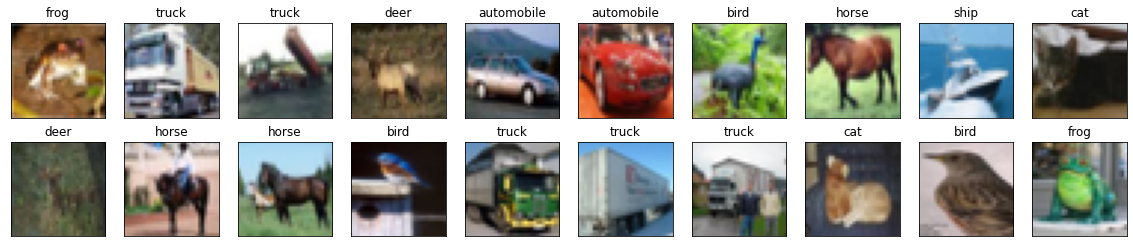

In [ ]:
# show some sample images
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  ax = plt.subplot(2, 10, idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(x_train[idx])
  plt.title(class_names[int(y_train[idx])])

In [ ]:
# change data type as float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [ ]:
# normalize image data 
x_train = x_train / 255.
x_test = x_test / 255.

In [ ]:
# one hot encoding
# Now we one hot encode outputs
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
# shape o images
print('Shape of taining images: ', x_train.shape)
print('Shape of taining labels: ', y_train.shape)
print()
print('Shape of testing images: ', x_test.shape)
print('Shape of testing labels: ', y_test.shape)

Shape of taining images:  (50000, 32, 32, 3)
Shape of taining labels:  (50000, 10)

Shape of testing images:  (10000, 32, 32, 3)
Shape of testing labels:  (10000, 10)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model = load_model('./drive/My Drive/PhD_Thesis/target_models/Mnet.h5')

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

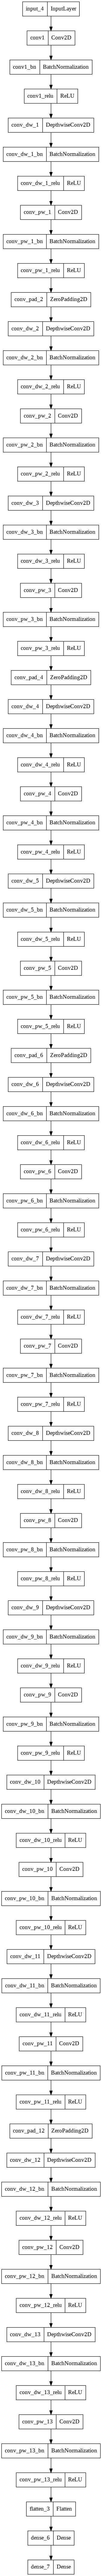

In [ ]:
tf.keras.utils.plot_model()

In [ ]:
x_test, y_test = x_test[:1000], y_test[:1000]

In [ ]:
predictions = model.predict(x_test)
#np.argmax(predictions[0])

In [ ]:
orig_loss, orig_accuracy = model.evaluate(x_test, y_test)
print()
print('Test Accuracy: ', round(orig_accuracy, 4))
print('Test Los: ', round(orig_loss, 4))

32/32 [==============================] - 2s 34ms/step - loss: 0.5863 - accuracy: 0.8140

Test Accuracy:  0.814
Test Los:  0.5863


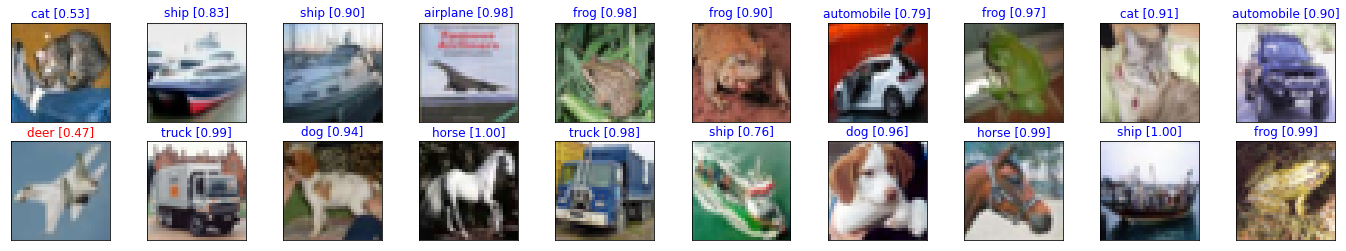

In [ ]:
#show some test images
fig = plt.figure(figsize=(24, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(x_test[idx])
  
  if class_names[int(np.argmax(predictions[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)

## 1. Fast Gradient Sign Attack and Reconstruction of Adversarial Example

In [ ]:
l = [] 
for i in np.arange(len(y_test)):
  y = np.argmax(y_test[i])
  l.append(y)

y_test = np.asarray(l)
y_test.shape

(1000,)

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

#images = ep.astensor(images)
#labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.FGSM()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.005)

# adversarial purtubation
perturb = adv_img - x_test

In [ ]:
predictions = model.predict(adv_img.numpy())

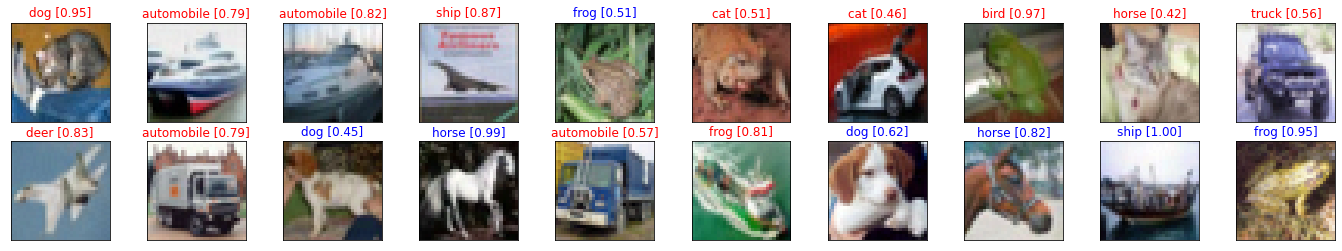

In [ ]:
#show some test images

fig = plt.figure(figsize=(24, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1))
  
  if class_names[np.argmax(predictions[idx])] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  15.3381
Average L2 Norm:  0.0088
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test, 10))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 34ms/step - loss: 2.4968 - accuracy: 0.3860

Model Accuracy on test images:  0.386
Model Loss on test images:  2.4968


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

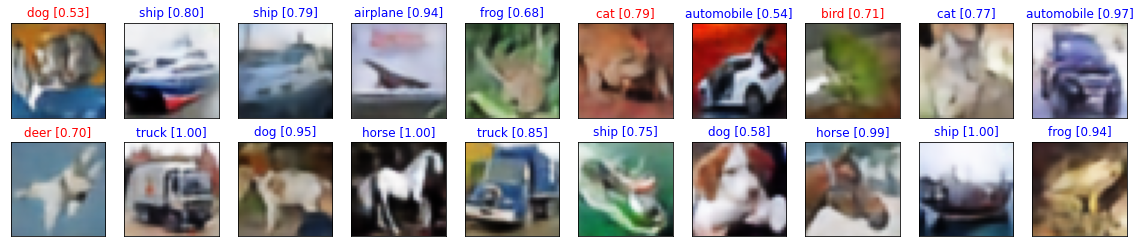

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9047

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.22517


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test, 10))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 34ms/step - loss: 0.9288 - accuracy: 0.7270

Model Accuracy on restored images:  0.727
Model Loss on test images:  0.9288


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8931


# 2. Basic Iterative Method (Attack) and Reconstruction of Adversarial Examples 

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.L2BasicIterativeAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.25)

# adversarial purtubation
perturb = adv_img - x_test

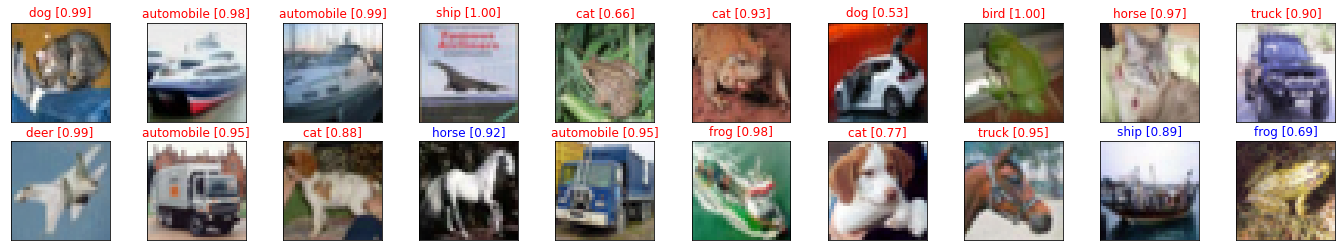

In [ ]:
adv_pred = model.predict(adv_img.numpy())

fig = plt.figure(figsize = (24, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx], 0, 1))
  
  if class_names[np.argmax(adv_pred[idx])] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  10.0816
Average L2 Norm:  0.0079
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 38ms/step - loss: 4.7734 - accuracy: 0.1550

Model Accuracy on test images:  0.155
Model Loss on test images:  4.7734


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove BIM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to BIM attack 
denise_images =d_model.predict(adv_img.numpy())

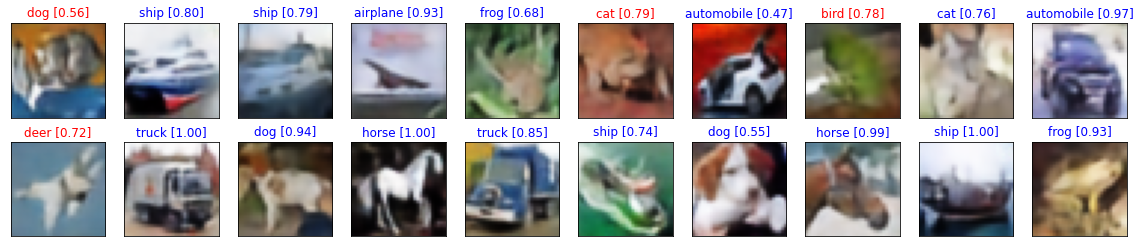

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9047

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.22639


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 36ms/step - loss: 0.9423 - accuracy: 0.7270

Model Accuracy on restored images:  0.727
Model Loss on test images:  0.9423


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8931


#3. Projected Gradient Descent Attack and Reconstruction of Adverasarial Examples

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.PGD()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.007)

# adversarial purtubation
perturb = adv_img - x_test

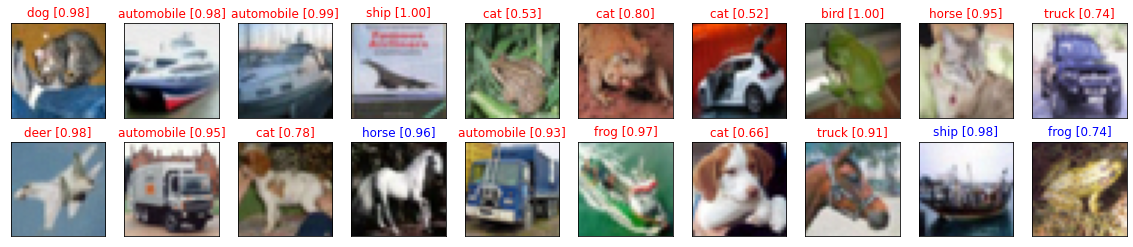

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx], 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy() / len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy() / len(x_test), 4))

Average L1 Norm:  15.8762
Average L2 Norm:  0.0098
Average L_inf Norm:  0.001


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 34ms/step - loss: 4.2354 - accuracy: 0.2030

Model Accuracy on test images:  0.203
Model Loss on test images:  4.2354


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove PGD putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to PGD attack 
denise_images =d_model.predict(adv_img.numpy())

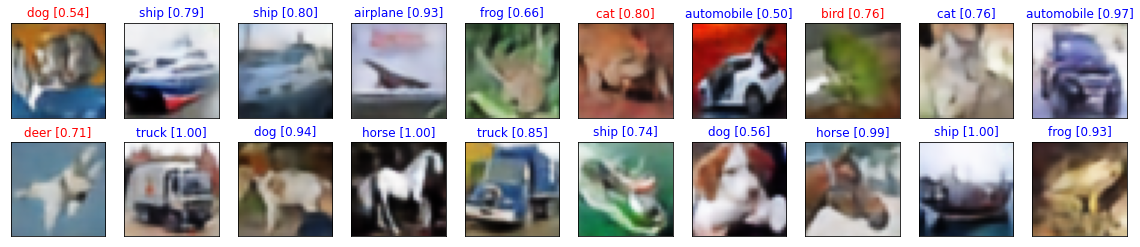

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)

In [ ]:
ssim = tf.image.ssim(x_test, denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9047

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.225624


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 33ms/step - loss: 0.9363 - accuracy: 0.7270

Model Accuracy on restored images:  0.727
Model Loss on test images:  0.9363


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8931


#4. Deep Fool Attack

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.L2DeepFoolAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 0.5)

# adversarial purtubation
perturb = adv_img - x_test

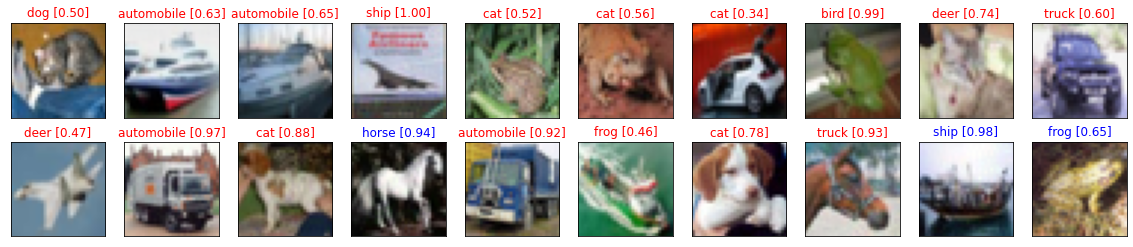

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  11.2612
Average L2 Norm:  0.0116
Average L_inf Norm:  0.0011


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 34ms/step - loss: 2.2465 - accuracy: 0.1810

Model Accuracy on test images:  0.181
Model Loss on test images:  2.2465


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove dfa putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_fgsm.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

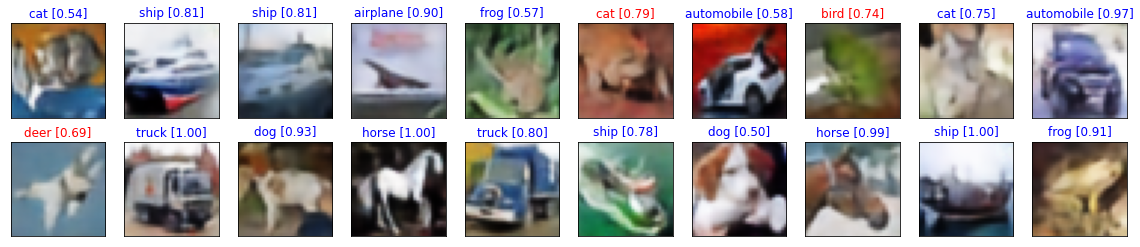

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9045

Average Peak Signal-to-Noise Ratio between original and restored Examples: 76.220764


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 35ms/step - loss: 0.9045 - accuracy: 0.7300

Model Accuracy on restored images:  0.73
Model Loss on test images:  0.9045


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.8968


# Carlini and Wanger Attack

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
pred = model.predict(x_test[:1000])

label = []
for i in range(len(pred)):
  y_pred = np.argmax(pred[i])
  l = label.append(y_pred) 


labels = np.asarray(label)

images = tf.cast(x_test[:1000], dtype = tf.float32)
labels = tf.cast(labels, dtype = tf.int32)

images = ep.astensor(images)
labels = ep.astensor(labels)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

# create attack
attack = foolbox.attacks.L2CarliniWagnerAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 5)

# adversarial purtubation
perturb = adv_img - x_test[:1000]

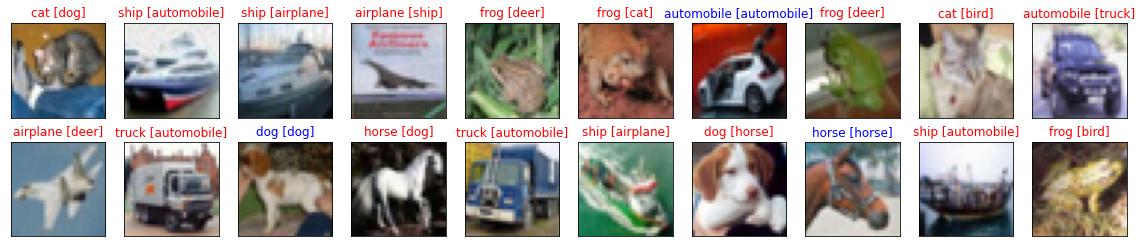

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1), cmap = 'gray')
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[np.argmax(y_test[idx])]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title(class_names[np.argmax(y_test[idx])] + " [" + class_names[int(np.argmax(adv_pred[idx]))] + "]", color = color)

In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), y_test[:1000])
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 13ms/step - loss: 1.1845 - accuracy: 0.1450

Model Accuracy on test images:  0.145
Model Loss on test images:  1.1845


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/cifar10/cifar10_cwa.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

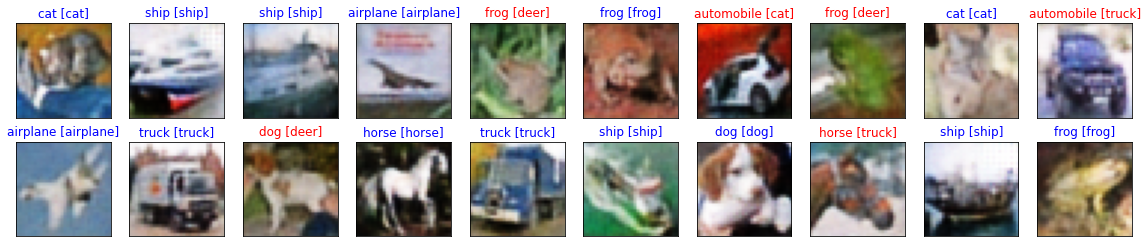

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  #plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  
  if class_names[np.argmax(y_test[idx])] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx], cmap = 'gray')
  plt.title(class_names[np.argmax(y_test[idx])] + ' [' + class_names[np.argmax(predictions[idx])] + ']', color =  color)
  

In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, y_test[:1000])
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 13ms/step - loss: 0.8965 - accuracy: 0.7150

Model Accuracy on restored images:  0.715
Model Loss on test images:  0.8965


In [ ]:
print('Sucess of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess of Defence Model:  0.9458


In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test[:100], dtype = tf.float32)
labels = tf.cast(y_test[:100], dtype = tf.int32)

print(images.shape)
print(labels.shape)

(100, 32, 32, 3)
(100,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.L2CarliniWagnerAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c, epsilons = 4)

# adversarial purtubation
perturb = adv_img - x_test[:100]

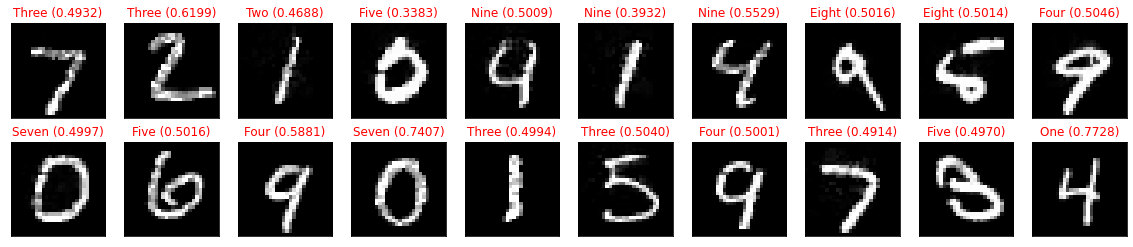

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy().reshape(28, 28), 0, 1), cmap = 'gray')
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_val[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s (%.4f)' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  21.6537
Average L2 Norm:  0.0885
Average L_inf Norm:  0.0018


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), y_test)
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 0s 5ms/step - loss: 0.7285 - accuracy: 0.2300

Model Accuracy on test images:  0.23
Model Loss on test images:  0.7285


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('./drive/My Drive/PhD_Thesis/Generative_Models/mnist_cwa.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

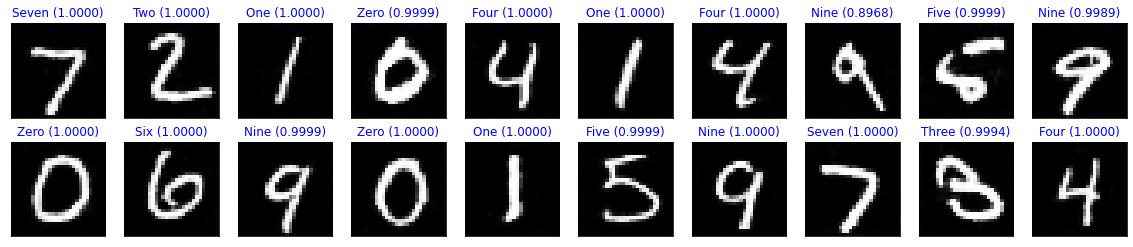

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_val[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx].reshape(28, 28), cmap = 'gray')
  plt.title('%s (%.4f)' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test, denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.9442

Average Peak Signal-to-Noise Ratio between original and restored Examples: 75.52581


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, y_test)
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 0s 4ms/step - loss: 0.0462 - accuracy: 0.9880

Model Accuracy on restored images:  0.988
Model Loss on test images:  0.0462


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  1.001


# 6. Spatial attack and Reconstruction of Adverasarial Examples

In [ ]:
#!pip install foolbox
import foolbox
import eagerpy as ep

In [ ]:
images = tf.cast(x_test, dtype = tf.float32)
labels = tf.cast(y_test, dtype = tf.int32)

print(images.shape)
print(labels.shape)

(1000, 32, 32, 3)
(1000,)


In [ ]:
# create fool Model
fmodel = foolbox.models.TensorFlowModel(model = model, bounds = (0, 255))

# set criteria
c = foolbox.criteria.Misclassification(labels)

eps = [0.3]

# create attack
attack = foolbox.attacks.SpatialAttack()

# create adversarial example
raw_adv, adv_img, success = attack(fmodel, images, criterion = c)

# adversarial purtubation
perturb = adv_img - x_test

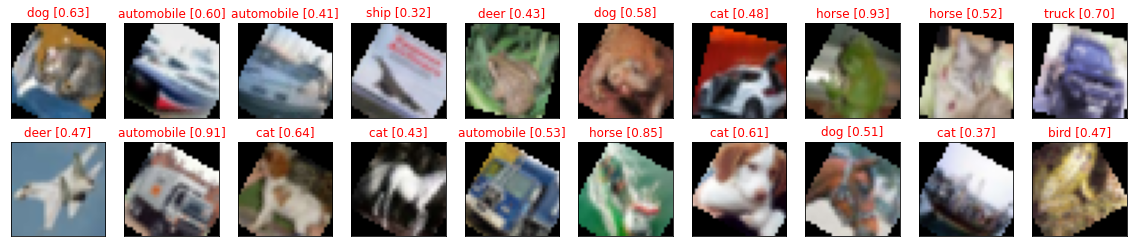

In [ ]:
adv_pred = model.predict(adv_img.numpy())
fig = plt.figure(figsize = (20, 4))

for idx in range(20):
  fig = plt.subplot(2, 10 , idx + 1, xticks = ([]), yticks = ([]))
  plt.imshow(np.clip(adv_img[idx].numpy(), 0, 1))
  
  if class_names[int(np.argmax(adv_pred[idx]))] == class_names[y_test[idx]]:
    color = 'blue'
  else:
    color = 'red'
  
  plt.title('%s [%.2f]' %(class_names[np.argmax(adv_pred[idx])], adv_pred[idx].max()), color = color)

In [ ]:
print("Average L1 Norm: ", round(tf.norm(perturb, ord = 1).numpy() / len(x_test), 4))
print("Average L2 Norm: ", round(tf.norm(perturb, ord = 2).numpy()/ len(x_test), 4))
print("Average L_inf Norm: ", round(tf.norm(perturb - x_test, ord = np.inf).numpy()/ len(x_test), 4))

Average L1 Norm:  573.6688
Average L2 Norm:  0.5257
Average L_inf Norm:  0.002


In [ ]:
# accuracy and loss of model on adversarial images
adv_loss, adv_accuracy = model.evaluate(adv_img.numpy(), tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on test images: ", round(adv_accuracy, 4))
print("Model Loss on test images: ", round(adv_loss, 4))

32/32 [==============================] - 1s 35ms/step - loss: 2.5653 - accuracy: 0.0160

Model Accuracy on test images:  0.016
Model Loss on test images:  2.5653


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load denoising model to remove FGSM putrbation
d_model = tf.keras.models.load_model('/content/drive/MyDrive/PhD_Thesis/Generative_Models/cifar10/cifar10_spa.h5')

In [ ]:
# Restore adversarial images created due to FGSM attack 
denise_images =d_model.predict(adv_img.numpy())

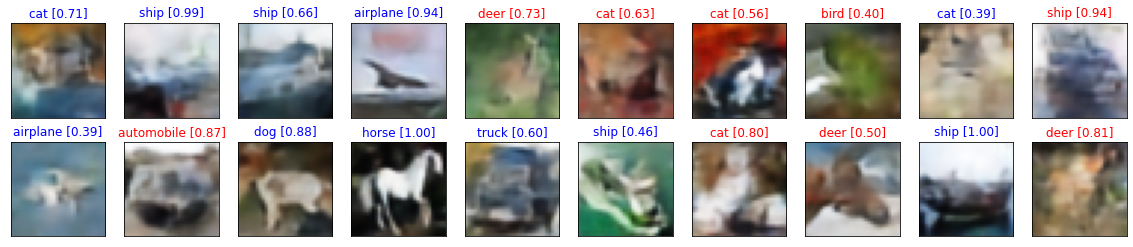

In [ ]:
# predict some restored images
predictions = model.predict(denise_images)

# show restored images
fig = plt.figure(figsize = (20, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx + 1, xticks = [], yticks = [])
  
  if class_names[y_test[idx]] == class_names[np.argmax(predictions[idx])]:
    color = 'blue'
  else:
    color = 'red'

  plt.imshow(denise_images[idx])
  plt.title('%s [%.2f]' %(class_names[np.argmax(predictions[idx])], predictions[idx].max()), color =  color)
  

In [ ]:
ssim = tf.image.ssim(x_test,denise_images , max_val = 1, filter_size = 11, filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
ssim = ssim.numpy()
print("Average Structure Similarity Index between original and restored Examples:", round(ssim.mean(), 4))
print()

psnr = tf.image.psnr(x_test, denise_images, max_val = 255)
psnr = psnr.numpy()
print("Average Peak Signal-to-Noise Ratio between original and restored Examples:", psnr.mean())

Average Structure Similarity Index between original and restored Examples: 0.6402

Average Peak Signal-to-Noise Ratio between original and restored Examples: 70.01643


In [ ]:
# accuracy and loss of model on restored images
rest_loss, rest_accuracy = model.evaluate(denise_images, tf.keras.utils.to_categorical(y_test))
print()
print("Model Accuracy on restored images: ", round(rest_accuracy, 4))
print("Model Loss on test images: ", round(rest_loss, 4))

32/32 [==============================] - 1s 34ms/step - loss: 1.7705 - accuracy: 0.5090

Model Accuracy on restored images:  0.509
Model Loss on test images:  1.7705


In [ ]:
print('Sucess rate of Defence Model: ', round(rest_accuracy / orig_accuracy, 4))

Sucess rate of Defence Model:  0.6253
